# [PyTorch Tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html)

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [107]:
# Copied code to load in the data
from pathlib import Path
import requests

DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
    content = requests.get(URL + FILENAME).content
    (PATH / FILENAME).open("wb").write(content)
        

import pickle
import gzip

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

In [111]:
# Values range from 0 to 255
x_train[0:3,125:135]

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.19921875, 0.62109375, 0.98828125,
        0.62109375, 0.1953125 , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ]],
      dtype=float32)

(50000, 784)

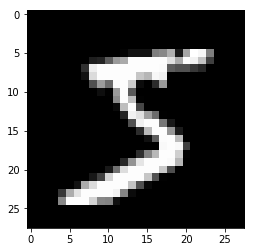

In [112]:
# Show an image
plt.imshow(x_train[0].reshape(28, 28), cmap='gray')
x_train.shape

## PyTorch

In [113]:
import torch

# Convert NumPy arrays to torch tensors
trn_X, trn_y, tst_X, tst_y = map(torch.tensor, (x_train, y_train, x_valid, y_valid))

trn_X = trn_X.type('torch.FloatTensor')
trn_y = trn_y.type('torch.FloatTensor')
tst_X = tst_X.type('torch.FloatTensor')
tst_y = tst_y.type('torch.FloatTensor')

In [114]:
type(trn_X)

torch.Tensor

### Create a neural network from scratch

In [127]:
import math

weights = torch.randn(784, 10) / math.sqrt(784)
# trailing _'s in PyTorch signifies an in-place operation
weights.requires_grad_()
# bias: kind of like a coefficient added to each term
bias = torch.zeros(10, requires_grad=True)
weights

tensor([[ 0.0313,  0.0016, -0.0329,  ...,  0.0535, -0.0144, -0.0748],
        [ 0.0015,  0.0078,  0.0048,  ..., -0.0050,  0.0185, -0.0324],
        [ 0.0282,  0.0165, -0.0158,  ..., -0.0715, -0.0269,  0.0582],
        ...,
        [-0.0069, -0.0310,  0.0235,  ..., -0.0268, -0.0216,  0.0123],
        [ 0.0336, -0.0081,  0.0587,  ...,  0.0059,  0.0062, -0.0381],
        [ 0.0176, -0.0060, -0.0302,  ...,  0.0013,  0.0530,  0.0189]],
       requires_grad=True)

In [128]:
# Activation function
def log_softmax(x):
    return x - x.exp().sum(-1).log().unsqueeze(-1)

log_softmax(torch.tensor([0.0, 1.0]))

tensor([-1.3133, -0.3133])

In [129]:
# Example to understand log_softmax
test_tensor = torch.tensor([[1, 2, 3], [4, 5, 6]]).type(torch.FloatTensor)
print(test_tensor.shape)
print(test_tensor.exp())
print(test_tensor.exp().sum(-1))
print(test_tensor.exp().sum(-1).log())
print(test_tensor.exp().sum(-1).unsqueeze(-1))
print(test_tensor - test_tensor.exp().sum(-1).unsqueeze(-1))

torch.Size([2, 3])
tensor([[  2.7183,   7.3891,  20.0855],
        [ 54.5982, 148.4132, 403.4288]])
tensor([ 30.1929, 606.4401])
tensor([3.4076, 6.4076])
tensor([[ 30.1929],
        [606.4401]])
tensor([[ -29.1929,  -28.1929,  -27.1929],
        [-602.4401, -601.4401, -600.4401]])


In [130]:
# Model for learning
def model(batch):
    return log_softmax(batch @ weights + bias)
# Note: @ is the dot product operation

In [131]:
# Check to make sure dimensions line up
trn_X.shape, weights.shape, bias.shape

(torch.Size([50000, 784]), torch.Size([784, 10]), torch.Size([10]))

In [132]:
batch_size = 64

batch = trn_X[0:batch_size]
predictions = model(batch)
predictions[0], predictions.shape

(tensor([-2.6653, -2.1349, -2.4770, -2.4885, -2.4820, -2.6367, -2.2303, -1.6889,
         -2.0255, -2.7208], grad_fn=<SelectBackward>), torch.Size([64, 10]))

In [133]:
# Loss function: the higher, the worse the model performs
def neg_log_likelihood(predictions, target):
    return -predictions[range(target.shape[0]), target.type(torch.LongTensor)].mean()

loss_function = neg_log_likelihood

In [134]:
print(predictions.shape, trn_y[0:batch_size].shape)
loss_function(predictions, trn_y[0:batch_size])

torch.Size([64, 10]) torch.Size([64])


tensor(2.3848, grad_fn=<NegBackward>)

In [135]:
# Accuracy function
def accuracy(predictions, target):
    preds = torch.argmax(predictions, dim=1)
    return (preds == target).float().mean()

In [136]:
accuracy(predictions, trn_y[0:batch_size])

tensor(0.1094)

#### Training the model

In [137]:
# Train
learning_rate = 0.5
epochs = 2

for epoch in range(epochs):
    # Run through all the data in batches
    for i in range((trn_X.shape[0] - 1) // batch_size + 1):
        start = i * batch_size
        end = start + batch_size
        batch_X = trn_X[start:end]
        batch_y = trn_y[start:end]
        predictions = model(batch_X)
        model_loss = loss_function(predictions, batch_y)

        # Calculate gradients on weights and bias
        model_loss.backward()
        # Update weights and bias, but don't calculate gradients for this process
        with torch.no_grad():
            weights -= weights.grad * learning_rate
            bias -= bias.grad * learning_rate
            # Set gradients to zero so gradients are correct for next loop
            weights.grad.zero_()
            bias.grad.zero_()

In [138]:
weights, bias

(tensor([[ 0.0313,  0.0016, -0.0329,  ...,  0.0535, -0.0144, -0.0748],
         [ 0.0015,  0.0078,  0.0048,  ..., -0.0050,  0.0185, -0.0324],
         [ 0.0282,  0.0165, -0.0158,  ..., -0.0715, -0.0269,  0.0582],
         ...,
         [-0.0069, -0.0310,  0.0235,  ..., -0.0268, -0.0216,  0.0123],
         [ 0.0336, -0.0081,  0.0587,  ...,  0.0059,  0.0062, -0.0381],
         [ 0.0176, -0.0060, -0.0302,  ...,  0.0013,  0.0530,  0.0189]],
        requires_grad=True),
 tensor([-0.4730,  0.4040,  0.1759, -0.3156,  0.0319,  1.7117, -0.1673,  0.8039,
         -1.8211, -0.3504], requires_grad=True))

In [140]:
# Print loss and accuracy of trained model
loss_function(model(tst_X), tst_y), accuracy(model(tst_X), tst_y)

(tensor(0.2927, grad_fn=<NegBackward>), tensor(0.9179))